### 讀入模型

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("C_batch_feature_norm.csv", index_col=0)
s_result_all = df.to_numpy()
print(s_result_all.shape)
mean_arr=s_result_all.transpose()
print(mean_arr.shape)


(180, 25)
(25, 180)


### 第一次計算特徵值

In [31]:
from main import allFeature, create_matrices, allFeatureNorm, SSDFeature
import cv2
import json 

#pixart7920_img="img/2023_1_16_15_56_33_Image.bmp" # theta=-78
#pixart7920_img="img/2023_1_16_11_43_53_Image.bmp" # theta=51
pixart7920_img="img/2023_1_16_11_43_43_Image.bmp" # theta=89

arr = cv2.cvtColor(cv2.imread(pixart7920_img), cv2.COLOR_BGR2GRAY)


t_value, y=allFeatureNorm(arr)
print(y)
print('t_value=',t_value)

# Convert the Python list to a JSON string
json_str = json.dumps(np.round(y,4).tolist())

# Print the JSON string
print(json_str)


[0.99038462 0.         0.         0.         0.         0.
 0.35774059 0.24267782 0.16527197 0.09832636 0.07531381 0.05857741
 0.78125    0.14583333 0.0625     0.         0.         0.
 0.81395349 0.10465116 0.06976744 0.         0.         0.        ]
t_value= 237
[0.9904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3577, 0.2427, 0.1653, 0.0983, 0.0753, 0.0586, 0.7812, 0.1458, 0.0625, 0.0, 0.0, 0.0, 0.814, 0.1047, 0.0698, 0.0, 0.0, 0.0]


### 第一次估計角度
* BallTree KD 搜尋最近特徵
* crop 42x42

(25, 180)
data_table.shape= (180, 24)
round_1 最近的角度: 89
round_1 最近角度與查詢資料的距離: 0.1345267860477524


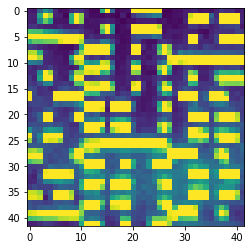

In [32]:


from sklearn.neighbors import BallTree
import numpy as np

# 創建一個24維度的數據表，共有180行
data_table = np.transpose(mean_arr[1:25:])
print(mean_arr.shape)
print("data_table.shape=",data_table.shape)

# 創建一個BallTree對象，並使用數據表構建k-d tree
tree = BallTree(data_table)


# 使用k-d tree查找最近鄰居，返回最近鄰居的索引和距離
distance, index = tree.query(y.reshape(1, -1), k=1)

round_1_degree=index[0][0]
round_1_cost=distance[0][0]

# 打印查找到的最近鄰居的索引和距離
print('round_1 最近的角度:', round_1_degree)
print('round_1 最近角度與查詢資料的距離:', round_1_cost)

if round_1_degree>90:
    theta =  round_1_degree-180
else:
    theta=round_1_degree
#print("theta=",theta)    
correct_challenge_1=create_matrices(arr, theta, scale=4)

plt.imshow(correct_challenge_1)

### 第二次計算特徵值

In [33]:
from main import allFeatureNorm_fine
fine_t_value, fine_feature=allFeatureNorm_fine(correct_challenge_1)
print(fine_feature)
print('fine_t_value=', fine_t_value)

[0.35257732 0.23917526 0.17113402 0.10927835 0.07216495 0.05360825
 0.95575221 0.03539823 0.         0.         0.         0.
 0.76699029 0.16504854 0.05825243 0.         0.         0.
 0.79120879 0.13186813 0.06593407 0.         0.         0.        ]
fine_t_value= 219


### 第二次估計角度
* BallTree KD 搜尋最近特徵


In [34]:

distance, index = tree.query(fine_feature.reshape(1, -1), k=1)
round_2_degree=index[0][0]
round_2_cost=distance[0][0]

# 打印查找到的最近鄰居的索引和距離
print('round_2 最近鄰居的索引:', round_2_degree)
print('round_2 最近鄰居與查詢資料的距離:', round_2_cost)


round_2 最近鄰居的索引: 4
round_2 最近鄰居與查詢資料的距離: 0.12597068002995385


### 旋轉判斷
* 當第二次估計角度有明顯改善 < 0.85*round_1_cost，採用的二次的答案
* 如果沒有明顯改善，採用的一次的答案

In [35]:
if round_2_cost < 0.85*round_1_cost:
    theta=round_2_degree+round_1_degree
else:
    theta =  round_1_degree

if theta>90:
    theta =  theta-180

print('theta=', theta)

theta= 89


### 顯示最後旋轉圖

(42, 42)


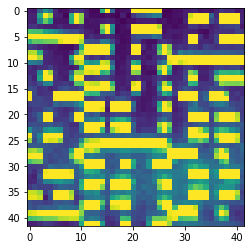

In [36]:
correct_challenge=create_matrices(arr, theta, scale=4)

print(correct_challenge.shape)
plt.imshow(correct_challenge)


### 9. 偵測pilot

v_sum= [2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 2 2 2 2 2]
v_sum[v_i]= 2
v_i= 11
h_i= 0


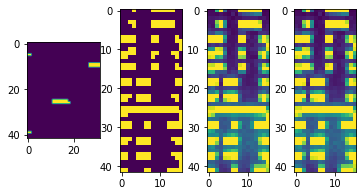

In [37]:
idDebug=True
isPlot = True

def pilotDetect(img, fine_t_value):

    bigger=img>=fine_t_value

    deep=10
    w=img.shape[1]-deep
    bigger_tmp=bigger[:,0:w]


    for i in range(deep):
        bigger_tmp=np.logical_and(bigger_tmp ,bigger[:,i:w+i])

    #plt.imshow(bigger_tmp)
    v_sum=np.sum(bigger_tmp,axis=0)
    #h_sum=np.sum(bigger_tmp,axis=1)
    
    #h_i=np.argmax(h_sum)
    
    #先找到零的部分
    for v_i_start in range(len(v_sum)):
        if v_sum[v_i_start]==0: break
    #在找之後非零的部分
    for v_i in range(v_i_start,len(v_sum)):
        if v_sum[v_i]>0: break
            
    h_i=np.argmax(bigger_tmp[v_i])
    if idDebug:
        print('v_sum=',v_sum)
        print('v_sum[v_i]=',v_sum[v_i])
        print("v_i=",v_i)
        print("h_i=",h_i)
        
    if isPlot:
        plt.subplots(1,4,figsize=(6,3)) 
        plt.subplot(141)
        plt.imshow(bigger_tmp)
        plt.subplot(142)
        plt.imshow(bigger[:,v_i+1:v_i+16+1])
        plt.subplot(143)
        plt.imshow(img[:,v_i+1:v_i+16+1])        
        plt.subplot(144)
        plt.imshow(img[:,v_i+1:v_i+16+1])
    #return img[:,v_i+1:v_i+16+1]
    return v_i,h_i


v_i,h_i=pilotDetect(correct_challenge, fine_t_value)
cropImg=correct_challenge[:,v_i+1:v_i+16+1]
cropImg_roll=np.roll(cropImg, -1, axis=1)
cropImg_roll=cropImg

#cropImg_180=cropImg*0
#rotate_180(cropImg, 42, 16, cropImg_180)

plt.imshow(cropImg_roll)
#cropImg_roll=cropImg_180

### 10. 峰值檢出

_peak_mean*1.125= 3441.0375
_peaks= [ 3  7 11 15 18 22 26 29 33 37]
mask= [ True  True  True  True  True  True  True  True  True  True]
peaks= [3, 7, 11, 15, 18, 22, 29, 33, 37]


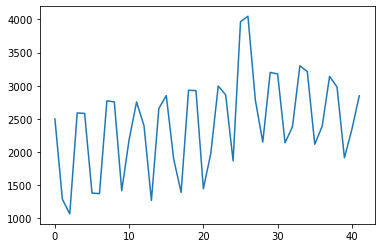

In [38]:
import scipy.signal
cropImg_roll_sum=np.sum(cropImg_roll,axis=1)
_peaks, _ = scipy.signal.find_peaks(cropImg_roll_sum)
_peaks_mean = np.mean(cropImg_roll_sum[_peaks])

mask = np.invert(np.isin(_peaks, [h_i-1,h_i,h_i+1]))
peaks=[]
#1.125 是經驗值，超過這個平均值，就認為是pilot
for i in range(len(_peaks)):
    #print(cropImg_roll_sum[_peaks[i]])
    #print(_peaks_mean*1.25)
    if cropImg_roll_sum[_peaks[i]] < _peaks_mean*1.125:
        peaks.append(_peaks[i])
#peaks=_peaks[mask]
#_zoom=_peaks[-1]-_peaks[0]
#zoom=_zoom/(len(_peaks)-1)/4
#wave_length=np.round(zoom*16)
#wave_length

if isPlot:
    plt.plot(cropImg_roll_sum)
    
if idDebug:
    print("_peak_mean*1.125=",_peaks_mean*1.125)
    print("_peaks=",_peaks)
    print("mask=",mask)
    print("peaks=",peaks)


### 11. fft 變換

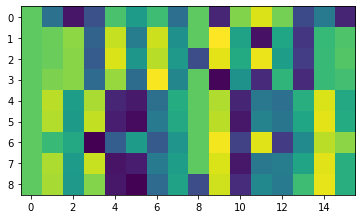

In [39]:
plt.imshow(cropImg_roll)

cropImg_roll_fft=np.fft.fft(cropImg_roll[peaks])
cropImg_roll_fft_ang=np.arctan2(cropImg_roll_fft.real,cropImg_roll_fft.imag)*180/np.pi
if isPlot:
    plt.imshow(cropImg_roll_fft_ang)